In [169]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Dataset

In [2]:
userDf = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")
loginDf = pd.read_csv("takehome_user_engagement.csv", encoding = "ISO-8859-1")
print(userDf.shape,loginDf.shape)

(12000, 10) (207917, 3)


In [3]:
userDf.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [4]:
loginDf.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


## Dataset Aggregation by Spark

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [6]:
userDf = spark.read.csv("takehome_users.csv", header=True, inferSchema=True)
loginDf=spark.read.csv("takehome_user_engagement.csv", header=True, inferSchema=True)
loginDf.columns

['time_stamp', 'user_id', 'visited']

In [7]:
loginDf.printSchema()

root
 |-- time_stamp: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- visited: integer (nullable = true)



In [8]:
loginDf.show(5)

+-------------------+-------+-------+
|         time_stamp|user_id|visited|
+-------------------+-------+-------+
|2014-04-22 03:53:30|      1|      1|
|2013-11-15 03:45:04|      2|      1|
|2013-11-29 03:45:04|      2|      1|
|2013-12-09 03:45:04|      2|      1|
|2013-12-25 03:45:04|      2|      1|
+-------------------+-------+-------+
only showing top 5 rows



In [9]:
'''Create a Spark Table View'''
userDf.createOrReplaceTempView("users")
loginDf.createOrReplaceTempView("logins")

### Top 5 login Counts

In [10]:
spark.sql('''select user_id, 
              count(*) as login_cnt
              from logins
              group by user_id
              order by login_cnt desc''').show(5)

+-------+---------+
|user_id|login_cnt|
+-------+---------+
|   3623|      606|
|    906|      600|
|   1811|      593|
|   7590|      590|
|   8068|      585|
+-------+---------+
only showing top 5 rows



### There is 33788  instances with times_of_login >=3 within 7-day period

In [11]:
spark.sql('''
select 
count(*)
from
(
(select 
t1.user_id, 
t1.timekey2,
count(t1.timekey2) as tk2_cnt
from
(
        (select
        user_id,
        UNIX_TIMESTAMP(time_stamp) as timekey1,
        floor(UNIX_TIMESTAMP(time_stamp) / (7*24*60*60)) as timekey2
        from logins) as t1
)
group by t1.user_id , t1.timekey2    
having (tk2_cnt) >=3
order by  tk2_cnt desc
) as t2)
''').show(100)

+--------+
|count(1)|
+--------+
|   33788|
+--------+



### Distribution of login counts in Daily basis
The following plot shows the ranking of counts of login. As we observe, 6235 users have ONLY 1 login after they signed up. The counts of 1-login is way more than the second ranked 2-login counts. This chart only shows the top 20 login Counts 

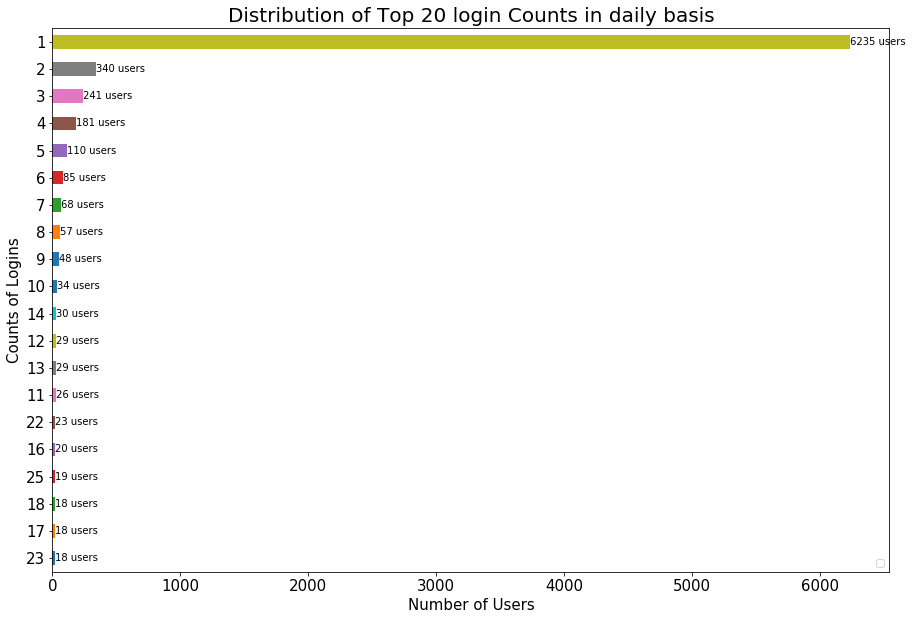

In [59]:
aggTbl = spark.sql('''
    select
    t1.login_cnt,
    count(t1.user_id) as user_cnt
    from
        (select
        user_id,
        count(user_id) as login_cnt
        from logins
        group by user_id) as t1
        
    group by t1.login_cnt
    order by user_cnt desc
''')

aggTbl=pd.DataFrame(aggTbl.collect(), columns=aggTbl.schema.names)
aggTbl.iloc[0:20].sort_values(by=["user_cnt"]).plot.barh(x="login_cnt", y="user_cnt", figsize=(15,10))
plt.title("Distribution of Top 20 login Counts in daily basis", fontsize=20)
plt.ylabel("Counts of Logins", fontsize=15)
plt.xlabel("Number of Users" , fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
level=0
for item in sorted(aggTbl.iloc[0:20].sort_values(by=["user_cnt"])["user_cnt"]):
    plt.text(x=item, y=level, s=str(item)+ " users", fontsize=10, ha="left", va="center")
    level+=1
plt.legend([],loc="lower right")
plt.show()

### Distribution of times_of_login >=3 within 7-day period
The following shows the ranking of counts of login in 7-day period. As oberved, there is 22890 cases that users only login ONCE within 7-day period. The second ranked is 2-time of login which has 11883 cases. For the purpose of this project, users would be considered as <font, color="blue">"adopted user"</font> only if they have login at least 3 times within a 7-day period (i.e. 9210 cases of 3-time login found in the following chart). 

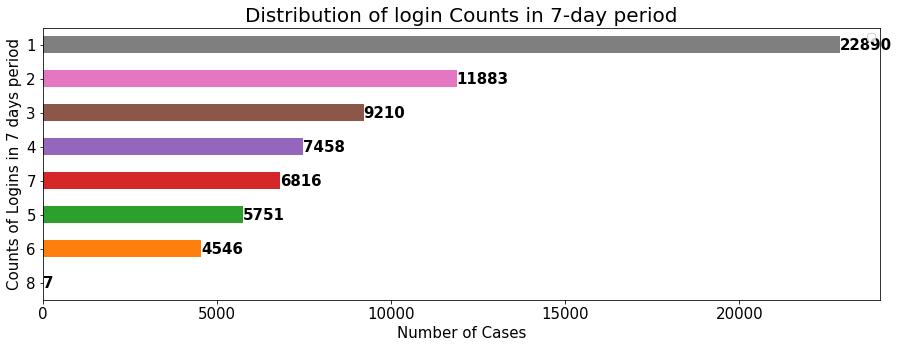

In [61]:
aggTbl=spark.sql('''
select
t2.tk2_cnt,
count(t2.tk2_cnt)
from
    (select 
    t1.user_id, 
    t1.timekey2,
    count(t1.timekey2) as tk2_cnt
    from
    (
        (select
        user_id,
        UNIX_TIMESTAMP(time_stamp) as timekey1,
        floor(UNIX_TIMESTAMP(time_stamp) / (7*24*60*60)) as timekey2
        from logins) as t1
    )
    group by t1.user_id , t1.timekey2    
    order by  tk2_cnt desc) as t2

group by t2.tk2_cnt
''')

aggTbl=pd.DataFrame(
    aggTbl.collect(), columns=aggTbl.schema.names)


aggTbl.sort_values(by=["count(tk2_cnt)"]).plot.barh(x="tk2_cnt", y="count(tk2_cnt)", 
                                                    figsize=(15,5))
plt.title("Distribution of login Counts in 7-day period", fontsize=20)
plt.ylabel("Counts of Logins in 7 days period", fontsize=15)
plt.xlabel("Number of Cases", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
level=0
for item in sorted(aggTbl["count(tk2_cnt)"]):
    plt.text(x=item, y=level, s=str(item), fontsize=15, 
             fontweight="bold",ha="left", va="center")
    level+=1
plt.legend([])
plt.show()


### Aggregate Users and Logins Table

After aggregating Logins and Users Table based on User_id, New Columns are added.  

Column <font, color="blue">label</font> is created:

 - <font, color="blue">label=0</font> means that user never have 3 or more times login within 7-day period
 
 - <font, color="blue">label=1</font> means that user have at least login once in 7-day period
 
Column <font, color="blue">tot_login_cnt</font> is created: Total count of daily logins per User

Column <font, color="blue">max_login_cnt_7day</font> is created: Total count of logins per 7-day period per User

In [225]:
aggTbl=spark.sql('''
      
select
users.*,
t5.tot_login_cnt,
t5.max_login_cnt_7day
from users

Left Join
    (select
    t4.user_id,
    count(t4.user_id) as tot_login_cnt,
    max(t4.max_login_cnt_7day) as max_login_cnt_7day
    from 
     (select
        logins.*,
        t3.max_login_cnt_7day
        from logins
            
        LEFT JOIN
            
            (select
            t2.user_id,
            max(login_cnt_7day) as max_login_cnt_7day
            from
               (select
                t1.user_id,
                t1.timekey2,
                count(t1.timekey2) as login_cnt_7day
                from
                    (select
                    user_id,
                    UNIX_TIMESTAMP(time_stamp) as timekey1,
                    floor(UNIX_TIMESTAMP(time_stamp) / (7*24*60*60)) as timekey2
                    from logins) as t1

                group by t1.user_id, t1.timekey2) as t2
           group by t2.user_id) as t3
           
           on t3.user_id = logins.user_id) as t4
    group by t4.user_id) as t5
    
on users.object_id = t5.user_id
''')
aggTbl = pd.DataFrame(aggTbl.collect(),columns = aggTbl.schema.names)
print(aggTbl.shape)
print(aggTbl.columns)
aggTbl.sort_values(by=["max_login_cnt_7day"], ascending=False, inplace=True)
aggTbl.head(3)

(12000, 12)
Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'tot_login_cnt', 'max_login_cnt_7day'],
      dtype='object')


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,tot_login_cnt,max_login_cnt_7day
3911,1811,2012-06-19 16:09:31,Carvalho Eduardo,EduardoCunhaCarvalho@gmail.com,SIGNUP_GOOGLE_AUTH,1.400948e+09,1,1,33,NaN,593.0,8.0
7987,2316,2012-06-16 16:02:39,Carter Travis,TravisYCarter@gmail.com,ORG_INVITE,1.401898e+09,0,0,368,4489.0,496.0,8.0
2338,8029,2012-06-24 16:15:58,Oliveira Isabela,IsabelaCastroOliveira@gmail.com,SIGNUP_GOOGLE_AUTH,1.400948e+09,1,0,175,NaN,541.0,8.0


## Data Cleaning

In [226]:
'''Replace NA cell with 0 values in the following columns'''
aggTbl.tot_login_cnt[aggTbl.tot_login_cnt.isna() == True]=0
aggTbl.max_login_cnt_7day[aggTbl.max_login_cnt_7day.isna() == True]=0
aggTbl.invited_by_user_id[aggTbl.invited_by_user_id.isna() == True]=0
aggTbl.last_session_creation_time[aggTbl.last_session_creation_time.isna() == True]=0

/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.

In [227]:
'''Splitting signup date into year, month, day columns'''
aggTbl["creation_time_year"]=aggTbl["creation_time"].dt.year
aggTbl["creation_time_month"]=aggTbl["creation_time"].dt.month
aggTbl["creation_time_day"]=aggTbl["creation_time"].dt.day

In [228]:
'''Extract Email Extension column'''
'''new=aggTbl["email"].str.split("@", n=1,expand=True)
aggTbl["email_name"]=new[0]
aggTbl["email_ext"]=new[1]'''

'new=aggTbl["email"].str.split("@", n=1,expand=True)\naggTbl["email_name"]=new[0]\naggTbl["email_ext"]=new[1]'

In [229]:
'''dummy'''
aggTbl_dum = pd.get_dummies(aggTbl, columns=["creation_source"])

In [230]:
'''Nomalization'''
aggTbl_dum["last_session_creation_time"]=(aggTbl["last_session_creation_time"]-np.mean(aggTbl_dum["last_session_creation_time"]))/ np.std(aggTbl_dum["last_session_creation_time"])
aggTbl_dum["creation_time_year"]=(aggTbl["creation_time_year"]-np.mean(aggTbl_dum["creation_time_year"]))/ np.std(aggTbl_dum["creation_time_year"])
aggTbl_dum["creation_time_month"]=(aggTbl["creation_time_month"]-np.mean(aggTbl_dum["creation_time_month"]))/ np.std(aggTbl_dum["creation_time_month"])
aggTbl_dum["creation_time_day"]=(aggTbl["creation_time_day"]-np.mean(aggTbl_dum["creation_time_day"]))/ np.std(aggTbl_dum["creation_time_day"])
aggTbl_dum["org_id"]=(aggTbl["org_id"]-np.mean(aggTbl_dum["org_id"]))/ np.std(aggTbl_dum["org_id"])
aggTbl_dum["invited_by_user_id"]=(aggTbl["invited_by_user_id"]-np.mean(aggTbl_dum["invited_by_user_id"]))/ np.std(aggTbl_dum["invited_by_user_id"])
aggTbl_dum["tot_login_cnt"]=(aggTbl["tot_login_cnt"]-np.mean(aggTbl_dum["tot_login_cnt"]))/ np.std(aggTbl_dum["tot_login_cnt"])

In [231]:
pd.set_option('display.max_colwidth', -1)
display(aggTbl_dum.head(3))

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,tot_login_cnt,max_login_cnt_7day,creation_time_year,creation_time_month,creation_time_day,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
3911,1811,2012-06-19 16:09:31,Carvalho Eduardo,EduardoCunhaCarvalho@gmail.com,0.635435,1,1,-0.877737,-0.824193,8.955000,8.0,-1.466466,-0.073261,0.342311,0,0,0,0,1
7987,2316,2012-06-16 16:02:39,Carter Travis,TravisYCarter@gmail.com,0.636995,0,0,1.822754,0.336096,7.446098,8.0,-1.466466,-0.073261,0.001524,0,1,0,0,0
2338,8029,2012-06-24 16:15:58,Oliveira Isabela,IsabelaCastroOliveira@gmail.com,0.635435,1,0,0.266949,-0.824193,8.146104,8.0,-1.466466,-0.073261,0.910288,0,0,0,0,1


In [232]:
aggTbl_dum["max_login_cnt_7day"][aggTbl_dum["max_login_cnt_7day"]<3] =int(0)
aggTbl_dum["max_login_cnt_7day"][aggTbl_dum["max_login_cnt_7day"]>=3] =int(1)
aggTbl_dum["adopted_user"]=aggTbl_dum["max_login_cnt_7day"]
Counter(aggTbl_dum["adopted_user"])

/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Counter({0.0: 10559, 1.0: 1441})

In [233]:
'''Drop Columns'''
aggTbl_dum = aggTbl_dum.drop(columns=["object_id",
                                      "creation_time", 
                                      "name", 
                                      "email",
                                      "max_login_cnt_7day"])

## Correlation
The following shows some features that are correlated with the "<font, color="blue"> adopted_user</font>" which represent users have login 3 days within 7-day period. Other than the following two features, correlation values of the the rest of the features are basically less than 0.01. In this case, I would recommend to pay more attention to the machine part to see if there is any particular pattern generated from other features.

Highly correlated features:
 - "last_session_creation_time": Postive correlated with the target label which mean the later the last login time, the higher chance the user is **adopted user**.
 
 - "tot_login_cnt": Positive correlated with the target label which means the more counts of the user login, the higher chance the user is **adopted user**.

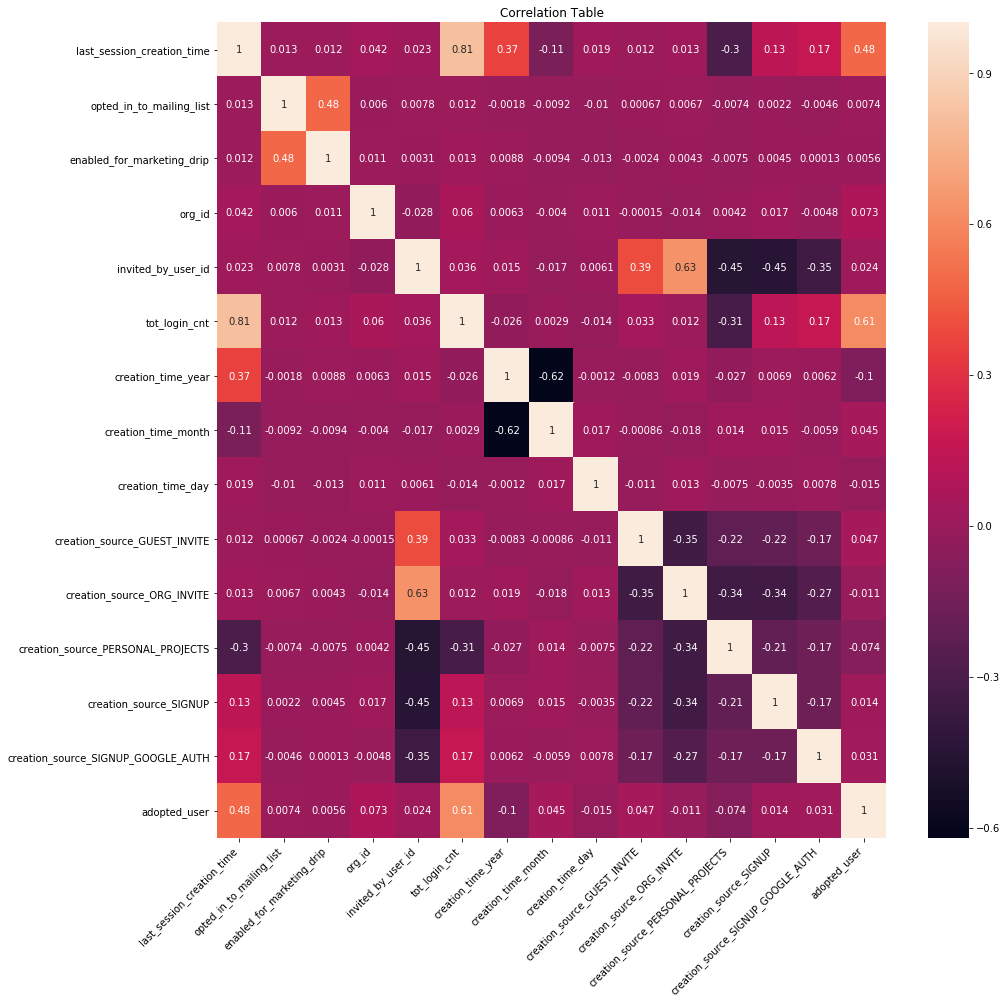

In [234]:
import seaborn as sns
plt.figure(figsize=(15,15))
ax=sns.heatmap(aggTbl_dum.corr(method="spearman"), annot=True)
plt.xticks(rotation=45, ha="right")
plt.title("Correlation Table")
#plt.xticks(rotation=45)
plt.show()

## Store data for Machine Learning

In [236]:
import pickle

with open("./data/XnormalizedDataPickle", "wb") as file:
    pickle.dump(np.array(aggTbl_dum.drop(columns=["adopted_user"])),file)
    
with open("./data/ynormalizedDataPickle", "wb") as file:
    pickle.dump(np.array(aggTbl_dum["adopted_user"]),file)    

In [237]:
with open("./data/XnormalizedDataPickle", "rb") as file:
    X = pickle.load(file)
    
with open("./data/ynormalizedDataPickle", "rb") as file:
    y = pickle.load(file)      
    
print(X.shape, y.shape)
#print(X.head(3), y.head(3))

(12000, 14) (12000,)


## Machine Learning

### Random Forest Classifier

In [252]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

'''
Train Classifier by using Cross Validation Method
'''
scoring=["accuracy", "recall", "precision"] #Measuring Metrics
cv=5 #Number of Cross Validation Partitions

#Store Train and Test Score
train_accuracy_lst, train_recall_lst, train_precision_lst=[],[],[]
test_accuracy_lst,test_recall_lst, test_precision_lst=[],[],[]

#List to store "Number of Estimator"
n_estimator_lst = [100,200,500,700,1000]
for n_estimator in n_estimator_lst:
    clf= RandomForestClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
    scores=cross_validate(clf, X,y, cv=cv,scoring=scoring, return_train_score=True)
    
    train_precision_lst.append(scores["train_precision"])    
    train_recall_lst.append(scores["train_recall"])
    train_accuracy_lst.append(scores["train_accuracy"])
    
    
    test_precision_lst.append(scores["test_precision"])    
    test_recall_lst.append(scores["test_recall"])
    test_accuracy_lst.append(scores["test_accuracy"])  
    
'''
Store Measurment metrics into DataFrame
'''    
metricDf=pd.DataFrame(list(zip(n_estimator_lst,
                               train_accuracy_lst,train_recall_lst, train_precision_lst,
                               test_accuracy_lst,test_recall_lst, test_precision_lst)), 
                      columns=["n_estimator_lst",
                               "train_accuracy_lst","train_recall_lst", "train_precision_lst",
                               "test_accuracy_lst","test_recall_lst", "test_precision_lst"]) 

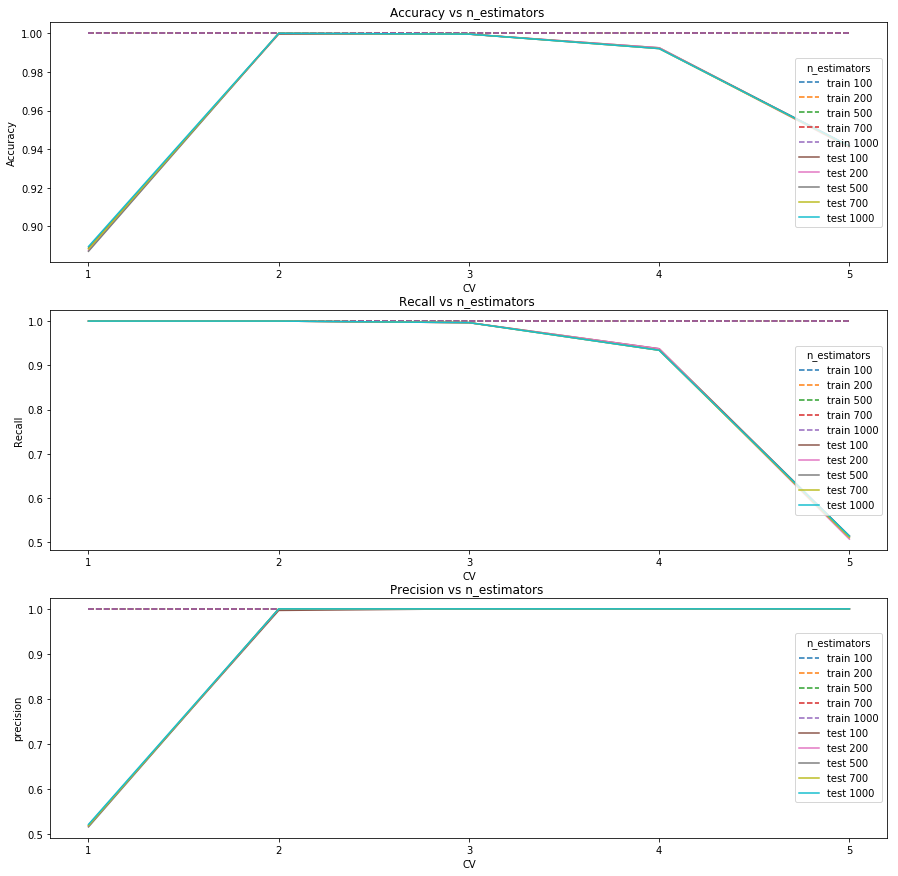

In [253]:
'''
Plot Measurment metrics from the above trained models.
'''
fig=plt.figure(figsize=(15,15))

#Metric 1
ax1=fig.add_subplot(3,1,1)
for i in range(0,metricDf["train_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["train_accuracy_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_accuracy_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Accuracy vs n_estimators ")
plt.ylabel("Accuracy")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

#Metric 2
ax1=fig.add_subplot(3,1,2)
for i in range(0,metricDf["train_recall_lst"].shape[0]):
    ax1.plot(metricDf["train_recall_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_recall_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Recall vs n_estimators ")
plt.ylabel("Recall")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")


#Metric 3
ax1=fig.add_subplot(3,1,3)
for i in range(0,metricDf["train_precision_lst"].shape[0]):
    ax1.plot(metricDf["train_precision_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_precision_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Precision vs n_estimators ")
plt.ylabel("precision")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

plt.show()

In [254]:
def Barplot_avg_metric(x, y, metric):
    fig = plt.figure(figsize=(15,5))
#    ax=fig.add_subplot(1,3,axNo)
    plt.bar(x=x, height=y, width=50)
    plt.ylim(top=max(y)+0.02, bottom=min(y)-0.02)
    plt.xticks(ticks=np.arange(0,1100,100))
    plt.title("%s vs n_estimator" %(metric))
    plt.ylabel("%s" %(metric))
    plt.xlabel("n_estimators")
    plt.show()
    

In [255]:
avg_test_recall_lst, avg_test_accuracy_lst, avg_test_precision_lst=[], [], []

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    avg_test_accuracy_lst.append(np.mean(metricDf["test_accuracy_lst"][i])) 

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    avg_test_recall_lst.append(np.mean(metricDf["test_recall_lst"][i]))

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    avg_test_precision_lst.append(np.mean(metricDf["test_precision_lst"][i])) 

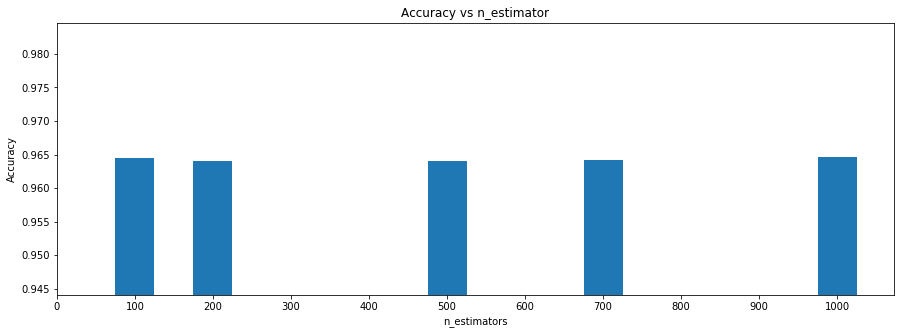

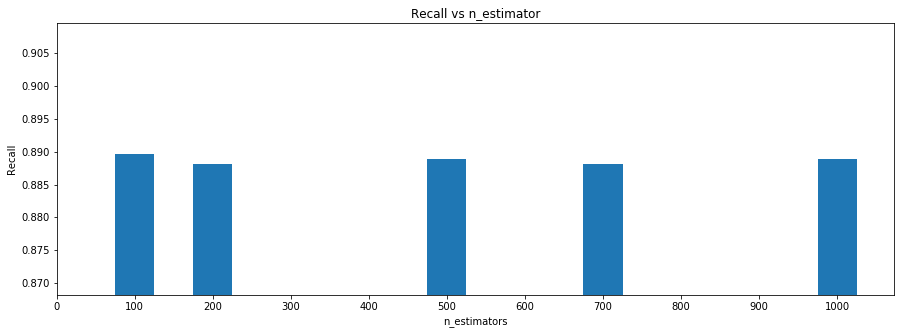

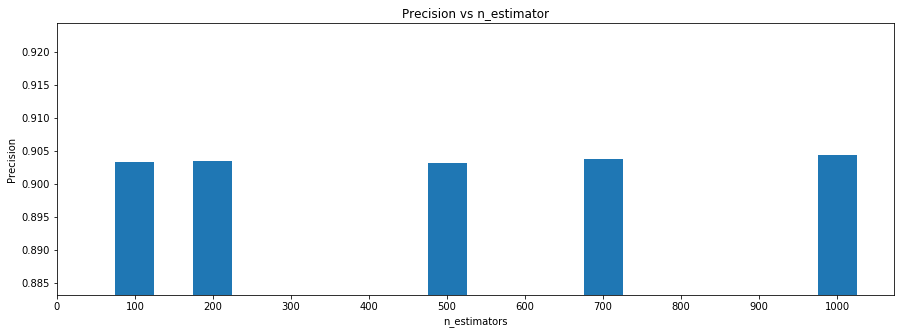

In [256]:
Barplot_avg_metric(n_estimator_lst,avg_test_accuracy_lst, "Accuracy")
Barplot_avg_metric(n_estimator_lst,avg_test_recall_lst, "Recall")
Barplot_avg_metric(n_estimator_lst,avg_test_precision_lst, "Precision")

### Gradient Boosting Classifier

In [241]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

'''
Train Classifier by using Cross Validation Method
'''
scoring=["accuracy", "recall", "precision"] #Measuring Metrics
cv=5 #Number of Cross Validation Partitions

#Store Train and Test Score
train_accuracy_lst, train_recall_lst, train_precision_lst=[],[],[]
test_accuracy_lst,test_recall_lst, test_precision_lst=[],[],[]

#List to store "Number of Estimator"
n_estimator_lst = [100,200,500,700,1000]
for n_estimator in n_estimator_lst:
    clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
    scores=cross_validate(clf, X,y, cv=cv,scoring=scoring, return_train_score=True)
    
    train_precision_lst.append(scores["train_precision"])    
    train_recall_lst.append(scores["train_recall"])
    train_accuracy_lst.append(scores["train_accuracy"])
    
    
    test_precision_lst.append(scores["test_precision"])    
    test_recall_lst.append(scores["test_recall"])
    test_accuracy_lst.append(scores["test_accuracy"])  
    
'''
Store Measurment metrics into DataFrame
'''    
metricDf=pd.DataFrame(list(zip(n_estimator_lst,
                               train_accuracy_lst,train_recall_lst, train_precision_lst,
                               test_accuracy_lst,test_recall_lst, test_precision_lst)), 
                      columns=["n_estimator_lst",
                               "train_accuracy_lst","train_recall_lst", "train_precision_lst",
                               "test_accuracy_lst","test_recall_lst", "test_precision_lst"])    

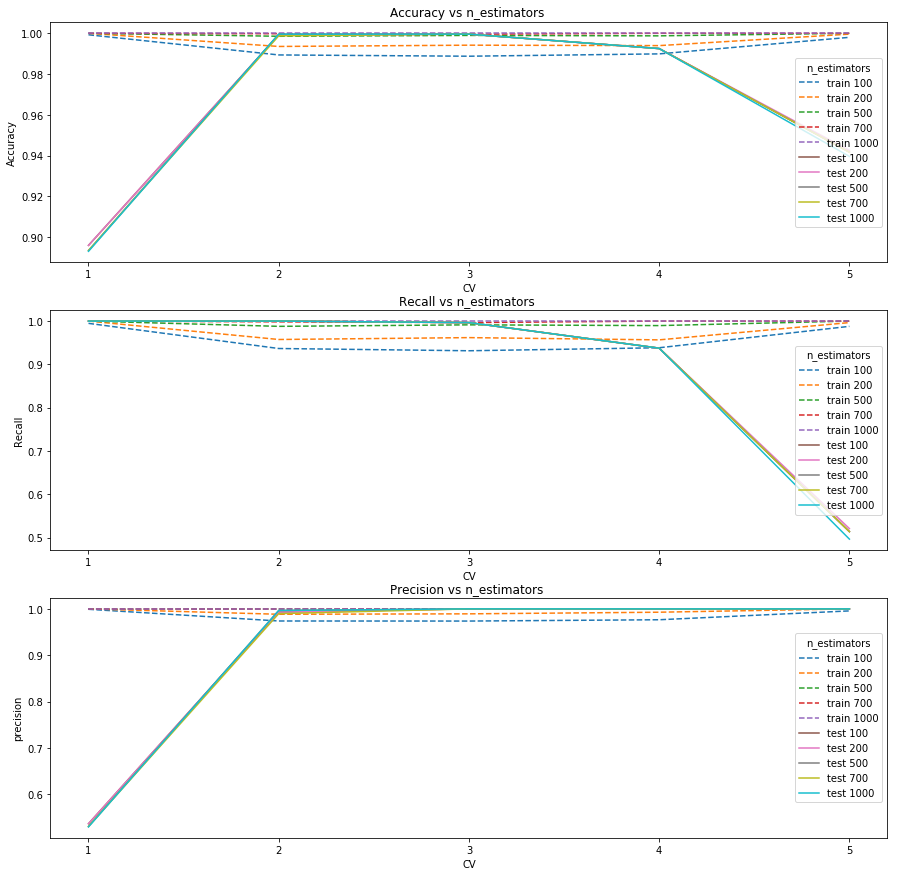

In [242]:
'''
Plot Measurment metrics from the above trained models.
'''
fig=plt.figure(figsize=(15,15))

#Metric 1
ax1=fig.add_subplot(3,1,1)
for i in range(0,metricDf["train_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["train_accuracy_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_accuracy_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Accuracy vs n_estimators ")
plt.ylabel("Accuracy")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

#Metric 2
ax1=fig.add_subplot(3,1,2)
for i in range(0,metricDf["train_recall_lst"].shape[0]):
    ax1.plot(metricDf["train_recall_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    ax1.plot(metricDf["test_recall_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Recall vs n_estimators ")
plt.ylabel("Recall")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")


#Metric 3
ax1=fig.add_subplot(3,1,3)
for i in range(0,metricDf["train_precision_lst"].shape[0]):
    ax1.plot(metricDf["train_precision_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    ax1.plot(metricDf["test_precision_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Precision vs n_estimators ")
plt.ylabel("precision")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

plt.show()

In [244]:
def Barplot_avg_metric(x, y, metric):
    fig = plt.figure(figsize=(15,5))
#    ax=fig.add_subplot(1,3,axNo)
    plt.bar(x=x, height=y, width=50)
    plt.ylim(top=max(y)+0.02, bottom=min(y)-0.02)
    plt.xticks(ticks=np.arange(0,1100,100))
    plt.title("%s vs n_estimator" %(metric))
    plt.ylabel("%s" %(metric))
    plt.xlabel("n_estimators")
    plt.show()
    

In [245]:
avg_test_recall_lst, avg_test_accuracy_lst, avg_test_precision_lst=[], [], []

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    avg_test_accuracy_lst.append(np.mean(metricDf["test_accuracy_lst"][i])) 

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    avg_test_recall_lst.append(np.mean(metricDf["test_recall_lst"][i]))

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    avg_test_precision_lst.append(np.mean(metricDf["test_precision_lst"][i])) 

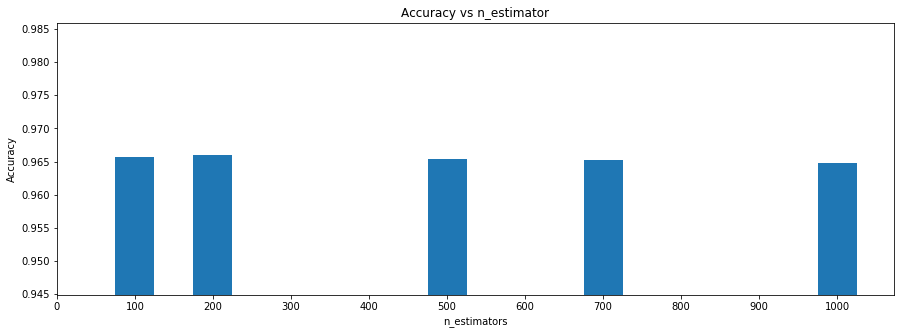

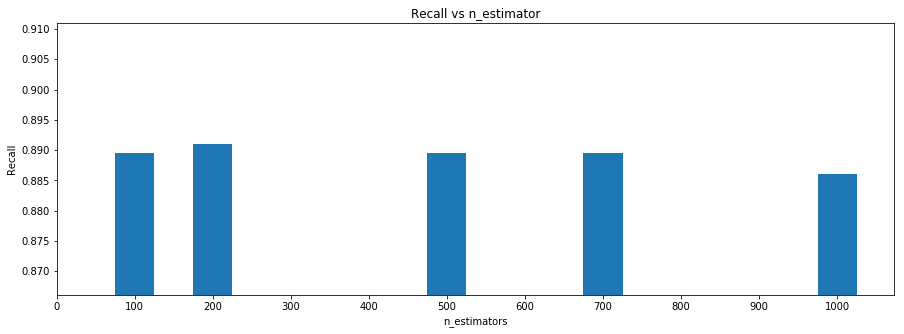

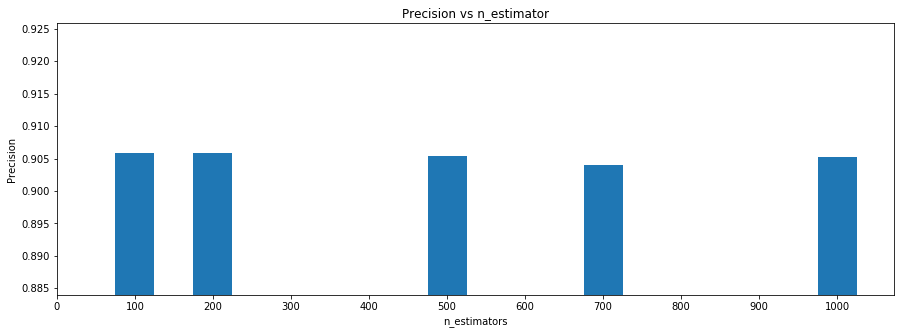

In [246]:
Barplot_avg_metric(n_estimator_lst,avg_test_accuracy_lst, "Accuracy")
Barplot_avg_metric(n_estimator_lst,avg_test_recall_lst, "Recall")
Barplot_avg_metric(n_estimator_lst,avg_test_precision_lst, "Precision")

## Compare models (t-test)
The t-test result shows that the P-value > t in both tests(i.e. Accuracy / Recall). In this case, The Null Hypothesis which means the both performance of learning algorithems are the same could not be rejected. In other words, their performance might be very close to each other. So that we would use the folloing feature importances values from both algorithems to search out the most relevant features to predict future user adoption.

In [258]:
'''t-test to compare model Accuracy'''    
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
import time

#scoring=["accuracy", "recall", "precision"]
sampling_times=50
n_estimator=200
cv=5
'''Random Sampling Accuracy for Model 1'''
clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
acc_gb_lst, recall_gb_lst=[],[]
for i in range(0,sampling_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    acc_gb_lst.append(accuracy_score(y_test, y_pred))
    recall_gb_lst.append(recall_score(y_test, y_pred))

In [259]:
'''Random Sampling Accuracy for Model 2'''
clf= RandomForestClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
acc_rf_lst, recall_rf_lst=[],[]
for i in range(0,sampling_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    acc_rf_lst.append(accuracy_score(y_test, y_pred))
    recall_rf_lst.append(recall_score(y_test, y_pred))

In [278]:
# Use scipy.stats.ttest_ind.
t, p = ttest_ind(acc_gb_lst, acc_rf_lst, equal_var=False)
print("Model Gradient Boosting Classifier Average Accuracy:", np.mean(acc_gb_lst))
print("Model Random Forest Classifier Average Accuracy:", np.mean(acc_rf_lst))
print("ttest_ind:            t = %g  p = %g" % (t, p))  


Model Gradient Boosting Classifier Average Accuracy: 0.9843282828282828
Model Random Forest Classifier Average Accuracy: 0.9856969696969696
ttest_ind:            t = -4.34497  p = 3.40576e-05


In [280]:
# Use scipy.stats.ttest_ind.
t, p = ttest_ind(recall_gb_lst, recall_rf_lst, equal_var=False)
print("Model Gradient Boosting Average Recall:", np.mean(recall_gb_lst))
print("ModelRandom Forest ClassifierAverage Recall:", np.mean(recall_rf_lst))
print("ttest_ind:            t = %g  p = %g" % (t, p))  

Model Gradient Boosting Average Recall: 0.922315528682154
ModelRandom Forest ClassifierAverage Recall: 0.9240756377639495
ttest_ind:            t = -0.791639  p = 0.430494


Result Table


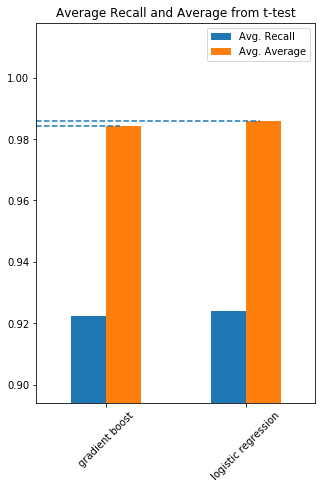

In [265]:
a1=np.array(list(zip((np.mean(recall_gb_lst), np.mean( recall_rf_lst)))))
a2=np.array(list(zip((np.mean(acc_gb_lst), np.mean( acc_rf_lst)))))
print("Result Table" )
ttestDf=pd.DataFrame(np.hstack((a1,a2)), columns=["Avg. Recall", "Avg. Average"], index=["gradient boost", "logistic regression"])


ttestDf.plot.bar(figsize=(5,7))
plt.ylim(top=max(acc_gb_lst)+0.03, bottom=min(recall_rf_lst))
plt.title("Average Recall and Average from t-test")
plt.xticks(rotation=45)
plt.axhline(y=np.mean(acc_gb_lst), linestyle="--", xmax=0.3)
plt.axhline(y=np.mean(acc_rf_lst), linestyle="--", xmax=0.8)
plt.show()

## Summary / Feature Importances
The following Bar Chart shows the values of "importances" of feature of machine learning algorithms. For the goal of this project, we attempted to discover the features that could lead to identify future user adoption. Based on the above, the prediction from 2 algorithm also generate over 90% accuracy. So that if we could search out the features which contribute significantly good amount of information to the prediction result, we might be able to utilize the algorithms to future adopted users. For this reason, we shall refer the following features importances result as our references. This meaning of this figure could be translated as the following: The higher the importance values, the more likely the features is relevant to the model. As observed, there is similarity between both charts which show the first 2 features (i.e. "tot_login_cnt", "last_session_creation_time") are actually ranked the same. Based on this Correlation values above and this reslt,  I would propose that the tot_login_cnt and last_session_creation_time features are the most relveant features to predict future user adoption. 

Recalled from the correlation part:
 - "last_session_creation_time": Postive correlated with the target label which mean the later the last login time, the higher chance the user is adopted user.

- "tot_login_cnt": Positive correlated with the target label which means the more counts of the user login, the higher chance the user is adopted user.

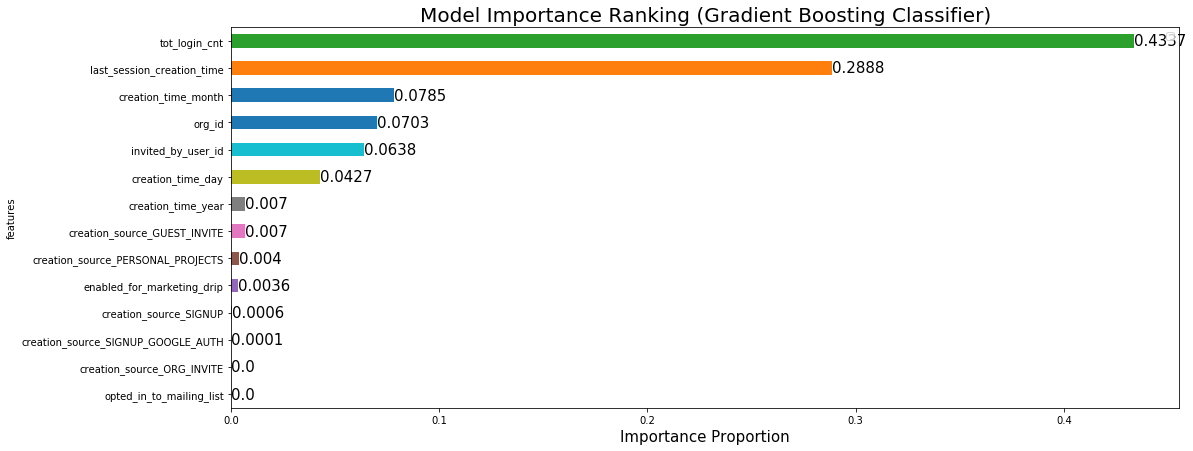

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


clf= GradientBoostingClassifier(n_estimators= 200, verbose=0, random_state=1)
clf.fit(X_train, y_train)

cols=aggTbl_dum.drop(columns=["adopted_user"]).columns
importances=clf.feature_importances_

importanceDf=pd.DataFrame(list(zip(cols, importances)), columns=["features", "importances"]).sort_values(by=["importances"], 
                                                                                           ascending=True)
importanceDf.plot.barh(x="features", y="importances", figsize=(17,7))
plt.xlabel("Importance Proportion", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Model Importance Ranking (Gradient Boosting Classifier)", fontsize=20)
plt.legend([])

level=0
level=0
for item in sorted(importanceDf["importances"]):
    plt.text(x=item, y=level, s=str(round(item,4)), fontsize=15, 
            ha="left", va="center")
    level+=1

plt.show()

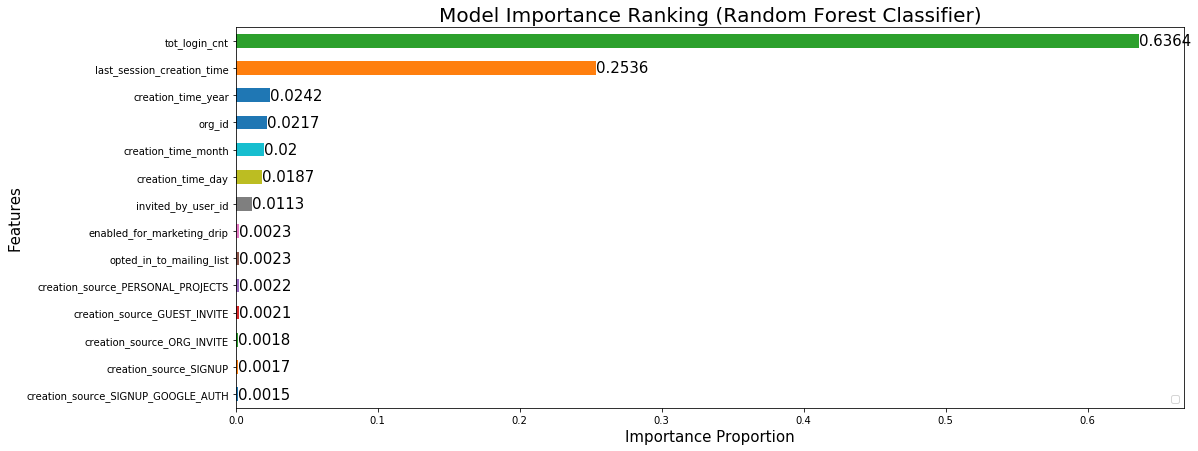

In [277]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


clf= RandomForestClassifier(n_estimators= 200, verbose=0, random_state=1)
clf.fit(X_train, y_train)

cols=aggTbl_dum.drop(columns=["adopted_user"]).columns
importances=clf.feature_importances_

importanceDf=pd.DataFrame(list(zip(cols, importances)), columns=["features", "importances"]).sort_values(by=["importances"], 
                                                                                           ascending=True)
importanceDf.plot.barh(x="features", y="importances", figsize=(17,7))
plt.xlabel("Importance Proportion", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Model Importance Ranking (Random Forest Classifier)", fontsize=20)
plt.legend([], loc="lower right")

level=0
for item in sorted(importanceDf["importances"]):
    plt.text(x=item, y=level, s=str(round(item,4)), fontsize=15, 
            ha="left", va="center")
    level+=1

plt.show()